In [60]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import dataloader
import torch.nn as nn



batch_sz = 4
learn_rate = 1e-3
train_num = 1000

#导入训练集数据
train_data = dataloader.DataLoader(
    datasets.CIFAR10(root='data/', train=True, transform=transforms.Compose([
        transforms.Resize(size=224),      
        transforms.ToTensor(),      
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])         
    ]), download=True), shuffle=True, batch_size=batch_sz,num_workers=1
)

# 导入测试集数据
train_test = dataloader.DataLoader(
    datasets.CIFAR10(root='data/', train=False, transform=transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]), download=True), shuffle=True, batch_size=batch_sz,num_workers=1
)


SyntaxError: invalid syntax (2552720017.py, line 6)

In [44]:

First=True
for x,label in train_data:
    if(First):
        print(x.shape)
        First=False
    break

torch.Size([4, 3, 224, 224])


In [45]:
class Bottleneck(nn.Module):

    #每个stage中维度拓展的倍数
    extention=4

    #定义初始化的网络和参数
    def __init__(self,inplane,midplane,stride,downsample=None):
        super(Bottleneck,self).__init__()

        self.conv1=nn.Conv2d(inplane,midplane,kernel_size=1,stride=stride,bias=False)
        self.bn1=nn.BatchNorm2d(midplane)
        self.conv2=nn.Conv2d(midplane,midplane,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(midplane)
        self.conv3=nn.Conv2d(midplane,midplane*self.extention,kernel_size=1,stride=1,bias=False)
        self.bn3=nn.BatchNorm2d(midplane*self.extention)
        self.relu=nn.ReLU(inplace=False)
        
        self.downsample=downsample
        self.stride=stride

        
    def forward(self,x):
        #参差数据
        residual=x
        
        #卷积操作
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.relu(self.bn2(self.conv2(out)))
        out=self.relu(self.bn3(self.conv3(out)))

        #是否直连（如果时Identity block就是直连；如果是Conv Block就需要对参差边进行卷积，改变通道数和size）
        if(self.downsample!=None):
            residual=self.downsample(x)
        
        #将参差部分和卷积部分相加
        out=out+residual
        out=self.relu(out)

        return out
    def make_layer(self,block,midplane,block_num,stride=1):
        '''
            block:block模块
            midplane：每个模块中间运算的维度，一般等于输出维度/4
            block_num：重复次数
            stride：Conv Block的步长
        '''

        block_list=[]

        #先计算要不要加downsample模块
        downsample=None
        if(stride!=1 or self.inplane!=midplane*block.extention):
            downsample=nn.Sequential(
                nn.Conv2d(self.inplane,midplane*block.extention,stride=stride,kernel_size=1,bias=False),
                nn.BatchNorm2d(midplane*block.extention)
            )


        #Conv Block
        conv_block=block(self.inplane,midplane,stride=stride,downsample=downsample)
        block_list.append(conv_block)
        self.inplane=midplane*block.extention

        #Identity Block
        for i in range(1,block_num):
            block_list.append(block(self.inplane,midplane,stride=1))
        
        return nn.Sequential(*block_list)

In [46]:
class ResNet(nn.Module):

    #初始化网络结构和参数
    def __init__(self,block,layers,num_classes=1000):
        #self.inplane为当前的fm的通道数
        self.inplane=64

        super(ResNet,self).__init__()

        #参数
        self.block=block
        self.layers=layers

        #stem的网络层
        self.conv1=nn.Conv2d(3,self.inplane,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(self.inplane)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,padding=1,stride=2)

        #64，128，256，512是指扩大4倍之前的维度,即Identity Block的中间维度
        self.stage1=self.make_layer(self.block,64,self.layers[0],stride=1)
        self.stage2=self.make_layer(self.block,128,self.layers[1],stride=2)
        self.stage3=self.make_layer(self.block,256,self.layers[2],stride=2)
        self.stage4=self.make_layer(self.block,512,self.layers[3],stride=2)

        #后续的网络
        self.avgpool=nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.extention, num_classes)




    
    def forward(self,x):
        
        #stem部分:conv+bn+relu+maxpool
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.maxpool(out)

        #block
        out=self.stage1(out)
        out=self.stage2(out)
        out=self.stage3(out)
        out=self.stage4(out)

        #分类
        out=self.avgpool(out)
        out = torch.flatten(out, 1)
        out=self.fc(out)


        return out
    
    def make_layer(self,block,midplane,block_num,stride=1):
        '''
            block:block模块
            midplane：每个模块中间运算的维度，一般等于输出维度/4
            block_num：重复次数
            stride：Conv Block的步长
        '''

        block_list=[]

        #先计算要不要加downsample模块
        downsample=None
        if(stride!=1 or self.inplane!=midplane*block.extention):
            downsample=nn.Sequential(
                nn.Conv2d(self.inplane,midplane*block.extention,stride=stride,kernel_size=1,bias=False),
                nn.BatchNorm2d(midplane*block.extention)
            )


        #Conv Block
        conv_block=block(self.inplane,midplane,stride=stride,downsample=downsample)
        block_list.append(conv_block)
        self.inplane=midplane*block.extention

        #Identity Block
        for i in range(1,block_num):
            block_list.append(block(self.inplane,midplane,stride=1))
        
        return nn.Sequential(*block_list)

In [52]:
device = torch.device('cpu')

In [55]:
if __name__ == "__main__":
    # #Identity Block的操作（Identity Block的dowmsample为None）
    # bottle=Bottleneck(256,64,stride=1,downsample=None)
    # x=torch.randn(1,256,300,300)
    # x=bottle(x)
    # print(x.shape)


    #Resnet
    resnet = ResNet(Bottleneck, [3, 4, 6, 3])
    

training on cuda:0


D:\Python\Anaconda\envs\pytorch\lib\site-packages\torch\autograd\__init__.py:199: UserWarning: Error detected in ReluBackward0. Traceback of forward call that caused the error:
  File "D:\Python\Anaconda\envs\pytorch\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Python\Anaconda\envs\pytorch\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Python\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\Python\Anaconda\envs\pytorch\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "D:\Python\Anaconda\envs\pytorch\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "D:\Python\Anaconda\envs\pytorch\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "D:\Python\Anaconda\envs\pytorch\lib\asyncio\base_events.

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [4, 2048, 7, 7]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

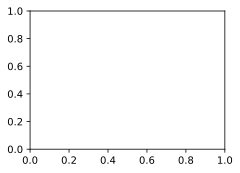

In [62]:
from d2l import torch as d2l
with torch.autograd.set_detect_anomaly(True):
    lr, num_epochs, batch_size = 0.01, 10, 32

    d2l.train_ch6(resnet, train_data,train_test , num_epochs, lr, d2l.try_gpu())


In [22]:
import os
import torch
print(torch.cuda.is_available())#是否有可用的gpu
print(torch.cuda.device_count())#有几个可用的gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#声明gpu
dev=torch.device('cuda:0')#调用哪个gpu
a=torch.rand(100,100).to(dev)


True
1


In [23]:

import os
import torch
print(torch.cuda.is_available())#是否有可用的gpu
print(torch.cuda.device_count())#有几个可用的gpu
print(torch.cuda.current_device())#可用gpu编号
print( torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))#可用gpu内存大小，可用gpu的名字
os.environ["CUDA_VISIBLE_DEVICES"] = "0"#声明gpu
dev=torch.device('cuda:0')#调用哪个gpu
a=torch.rand(100,100).to(dev)


True
1
0
(8, 6) NVIDIA GeForce RTX 3060 Laptop GPU
